# LINK TO KAGGLE CONTEST

### https://www.kaggle.com/c/ue-data-ninja-otodom-challenge-2020/leaderboard

## SOME OF THE DATA IS NOT SHOWN BECAUSE OF THE STANDARD CONTEST RULES

### COMMENTS AND DOCUMENTATION IS WRITTEN IN POLISH LANGUAGE

In [ ]:
import os

import re
import numpy as np
import pandas as pd
from datetime import datetime 
from sklearn.preprocessing import StandardScaler


import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings

from tqdm import tqdm
tqdm.pandas()

from ast import literal_eval

from IPython.display import display
pd.set_option('display.max_columns', None)

from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm

from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import plot_importance

warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

# Etap feature engineering:


1. opisz proces tworzenia zbioru treningowego dla modelu,
2. przedstaw ostateczny proces przetwarzania danych na przykładzie wybranego zbioru walidacyjnego (wybranego),
3. uzasadnij wybrane i stworzone cechy (jak zostały, jak ocenione, jak dokonany został proces redukcji).

## PREPROCESSING, DATA MINING, FEATURE ENGINEERING

#### Na początku załadujemy pliki csv train, test, districts, citites

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
districts = pd.read_csv('districts.csv')
cities = pd.read_csv('cities.csv')

#### Przypisujemy do ntrain, ntest ich długość, tak żeby w przy późniejszym łączeniu train i test łatwo było nam rozłączyć te dane.

In [6]:
ntrain = train.shape[0]
ntest = test.shape[0]

#### Również wartości cen w pliku 'train' będą niezbędne do wyłączenia. Najlepierw zapisujemy je jako 'y_train' (analogia y do ceny jako zmiennej zależnej nasuwa się sama), a następnie usuwamy z tabeli 'train'

In [7]:
y_train = train.price.values

In [8]:
train.drop(columns=['price'], inplace=True)

sprawdzamy czy ilość kolumn w 'train' oraz 'test' jest taka sama

In [9]:
print(f'Train shape: {train.shape}, test shape: {test.shape}')

Train shape: (832011, 10), test shape: (138136, 10)


### Łączymy 'train' oraz 'test' i zapisujemy jako 'data'

In [10]:
data = pd.concat([train, test], copy=False)

### Łączymy 'data' z 'cities' tworząc 'merged'

In [11]:
merged = data.merge(cities, how='left', left_on='city_id', right_on='id', copy=False)

usuwamy 'id_y', ze względu, iż jest to kopia 'city_id'

In [12]:
merged.drop(columns=['id_y'], inplace=True)

zmieniamy nazwy przed dołączeniem 'districts'

In [13]:
merged.rename(columns={'name_pl':'city_name', 'lon':'city_lon', 'lat':'city_lat'}, inplace=True)

### Dołączamy od 'merged' dane interesujące nas dane z 'districts'

In [14]:
merged = merged.merge(districts, how='left', left_on='district_id', right_on='id', copy=False)

usuwamy 'id', ze względu, iż jest to kopia 'district_id'

In [15]:
merged.drop(columns=['id'], inplace=True)

zmieniamy nazwy na bardziej jednoznaczne

In [16]:
merged.rename(columns={'name_pl':'district_name', 'lon':'district_lon', 'lat':'district_lat'}, inplace=True)

# Tworzymy nowe kolumny na podstawie danych z kolumny 'params'

Kolumna 'params'została wzięta jako czołowa kolumna, z której wyciągnąć można więcej informacji ze względu, iż jej struktura jest w miarę ustrukturyzowana. 

W dalszych rozważaniach nie będą brane pod uwagę kolumny 'description' oraz 'title' ze względu na ich chaotyczny charakter. Widzieliśmy potencjał w tych kolumnach w sensie NLP (Natural Language Processing), aczkolwiek z powodu braku czasu, nie zostały podjętę żadne z prób wnioskowania z tych dwóch kolumn.

#### najpierw stworzona została lista parametrów, które występują w kolumnie 'params'

In [18]:
new_cols = list(map(lambda x: x.split('<=>')[0], merged['params'][7].split('<br>')))
new_cols.remove('')

## Parsing kolumny 'params' 

Krok ten służy do wyciągnięcia dalszych informacji z kolumny 'params' oraz stworzenia nowych kolumn na podstawie tej pierwotnej. Również kolumna 'params' zostanie usunięta gdy już wszystkie informacje zostaną z niej usunięte. Naszym wiądącym Data Framem jest 'merged' natomiast po tym kroku zmieniamy nazwę na tą pierwotną czyli 'data'

Data frame 'merged' posiada na ten moment 16 kolumn

In [20]:
merged.shape

(970147, 16)

In [21]:
%%time
dicts_of_params = []
for params in merged['params']:
    dicts_of_params.append({entry[0]: entry[1] if len(entry)>1 else None 
                             for entry in [i.split('<=>') for i in params.split('<br>')]})

params = {col:[params_dict[col] if col in params_dict.keys() else np.NaN for params_dict in dicts_of_params] for col in new_cols}
params = {col:[i if i is not '' else np.NaN for i in params[col]] for col in params.keys()}

params_df = pd.DataFrame.from_dict(params)
data = pd.concat([merged.drop(columns=['params']), params_df], axis=1)
del merged

CPU times: user 31 s, sys: 1.41 s, total: 32.4 s
Wall time: 32.4 s


Natomiast w tym momencie, po parsingu Data Frame 'data' ('merged' został usunięty) posiada o 26 kolumn więcej 

In [22]:
data.shape

(970147, 42)

Jak wcześniej zostało wspomniane kolumny 'description' oraz 'title' nie będą potrzebne, tak więc można je usunąć.

In [24]:
data.drop(['description', 'title'], axis = 1, inplace = True)

Kolumny 'rent[currency]' oraz 'price[currency]' zostały uznane jako nie wnoszące nic ze względu, iż w przypadku 'price[currency]' nie ma innych niż 'PLN', natomiast w przypadku tej pierwszej kolumna 'rent' zostaje usunięta w dalszej części, tak więc 'rent[currency]' nie wniesie nic do modelu.

In [25]:
(data['price[currency]'] != 'PLN').sum()

0

In [26]:
data.drop(['rent[currency]'], axis = 1, inplace = True)

In [27]:
data.drop(['price[currency]'], axis = 1, inplace = True)

In [28]:
data.shape

(970147, 38)

# Featrue Engineering ciąg dalszy

Zauważalne było, iż w kolumnach 'extras_types', 'media_types', 'security_types', 'heating_types', 'fence_types', 'vicinity_types', 'access_types' znajdują się kolejne informację na temat jednostek. Idąc tym tropem przeprowadziliśmy wszelkie działania, które będą w stanie doprowadzić do momentu, w którym informacje te zostaną przełożone na kolumny zgodnie z techniką 'One Hot Encoding'.

## Poniżej opisane są wszelakie kroki, który umożliwyły dojście do pożądanego stanu rzeczy

In [30]:
data.shape

(970147, 38)

## Krok pierwszy

uporządkowanie, tak aby zamienić informacje rozdzielane przez '<->', w pożądanych kolumnach, na listę informacji.

## Krok drugi

1. sprawdzenie typów w tabeli 'data' 
2. zmiana typów jeśli jest potrzeba
3. sprawdznie typów jeszcze raz
4. wypełnienie NaN, we wszystkich kolumnach z powyższej listy 'categories' jako listę zawierającą 0
5. zamiana wszystkich wartości w tabeli 'data' na 'String' oraz przypisanie tabeli do nowej tabeli o nazwie 'df'

# 1

In [32]:
data.dtypes

id_x                     int64
created_at_first        object
category                object
is_business              int64
district_id            float64
city_id                  int64
region_id                int64
city_name               object
city_lon               float64
city_lat               float64
district_name           object
district_lon           float64
district_lat           float64
terrain_area            object
m                       object
market                  object
rooms_num               object
building_type           object
floors_num              object
building_material       object
build_year              object
garret_type             object
roof_type               object
roofing                 object
construction_status     object
windows_type            object
location                object
rent                    object
free_from               object
recreational            object
security_types          object
fence_types             object
heating_

# 2

In [33]:
data['build_year'] = data['build_year'].astype(np.float64)
data['m'] = data['m'].astype(np.float64)
data['terrain_area'] = data['terrain_area'].astype(np.float64)
data['is_bungalow'] = data['is_bungalow'].astype(np.float64)

# 3

In [34]:
data.dtypes

id_x                     int64
created_at_first        object
category                object
is_business              int64
district_id            float64
city_id                  int64
region_id                int64
city_name               object
city_lon               float64
city_lat               float64
district_name           object
district_lon           float64
district_lat           float64
terrain_area           float64
m                      float64
market                  object
rooms_num               object
building_type           object
floors_num              object
building_material       object
build_year             float64
garret_type             object
roof_type               object
roofing                 object
construction_status     object
windows_type            object
location                object
rent                    object
free_from               object
recreational            object
security_types          object
fence_types             object
heating_

# 4

In [35]:
data['extras_types'] = data['extras_types'].fillna("[0]")

data['media_types'] = data['media_types'].fillna("[0]")

data['security_types'] = data['security_types'].fillna("[0]")

data['heating_types'] = data['heating_types'].fillna("[0]")

data['fence_types'] = data['fence_types'].fillna("[0]")

data['vicinity_types'] = data['vicinity_types'].fillna("[0]")

data['access_types'] = data['access_types'].fillna("[0]")

# 5

In [36]:
data = data.applymap(str)

## Krok trzeci

tworzymy funckję, która pozwala na ostateczne rozdzielenie informacji na nowe kolumny 

In [38]:
def unsplit(colname):
    # zainincjowanie tabeli 'data', która znajduje się poza funkcją
    global data
    # parsowanie listy klumn z pomocą literal_eval z pakietu ast (które są stringami)
    sect = data[colname].apply(literal_eval)
    # bierzemy unikalne wartości z kolumny 'colname'
    seccols = np.unique([s for se in sect for s in se])
    # tworzenie one hotowych kolumn z kolumny 'colname'
    secarr = np.array([np.in1d(seccols, se) for se in sect])
    sectdata = pd.DataFrame(secarr, columns=seccols)
    # usunięcie kolumn, z których wyciągnięto dane oraz dołączenie nowych kolumn do tabeli 'data'
    data = pd.concat([data.drop(columns=colname), sectdata], axis=1)
    # zmiana wartości TRUE/FALSE na 1/0
    data = data*1

In [39]:
col_to_split = ['extras_types', 'media_types', 'security_types', 
                'heating_types', 'fence_types', 'vicinity_types', 
                'access_types']

for col in tqdm(col_to_split):
    unsplit(col)

100%|██████████| 7/7 [04:54<00:00, 42.01s/it]


podczas powyżej przedstawionego procesu usuniętych zostaje 7 kolumn, natomiast dodanych zostaje 61 nowych kolumn, co ostatecznie daje liczbę 98 kolumn

In [40]:
data.shape

(970147, 98)

powyżej zobaczyć można, iż stworzyło się 7 kolumn o nazwie '0', opuszczamy je i dostajemy ostatecznie 91 kolumn

In [42]:
data = data.drop("0", axis = 1)

In [43]:
data.shape

(970147, 91)

## Krok czwarty

podczas realizacji '5' punktu w 'kroku drugim' 31 kolumn, które zostały poddane transofrmacji, czyli zamienione na 'String' trzeba teraz zamienić z porotem na takie typy jakie były wcześniej

In [45]:
data.dtypes.head(31)

id_x                   object
created_at_first       object
category               object
is_business            object
district_id            object
city_id                object
region_id              object
city_name              object
city_lon               object
city_lat               object
district_name          object
district_lon           object
district_lat           object
terrain_area           object
m                      object
market                 object
rooms_num              object
building_type          object
floors_num             object
building_material      object
build_year             object
garret_type            object
roof_type              object
roofing                object
construction_status    object
windows_type           object
location               object
rent                   object
free_from              object
recreational           object
is_bungalow            object
dtype: object

In [46]:
data['id_x'] = data['id_x'].astype(np.float64)

In [47]:
data['id_x'].dtype

dtype('float64')

In [48]:
data['is_business'] = data['is_business'].astype(np.float64)

In [49]:
data['is_business'].dtypes

dtype('float64')

In [50]:
data['region_id'] = data['region_id'].astype(np.float64)
data['region_id'].dtypes

dtype('float64')

In [51]:
data['city_lon'] = data['city_lon'].astype(np.float64)
data['city_lon'].dtypes

dtype('float64')

In [52]:
data['city_lat'] = data['city_lat'].astype(np.float64)
data['city_lat'].dtypes

dtype('float64')

In [53]:
data['district_lon'] = data['district_lon'].astype(np.float64)
data['district_lon'].dtypes

dtype('float64')

In [54]:
data['district_lat'] = data['district_lat'].astype(np.float64)
data['district_lat'].dtypes

dtype('float64')

In [55]:
data['terrain_area'] = data['terrain_area'].astype(np.float64)
data['terrain_area'].dtypes

dtype('float64')

In [56]:
data['m'] = data['m'].astype(np.float64)
data['m'].dtypes

dtype('float64')

In [57]:
data['build_year'] = data['build_year'].astype(np.float64)
data['build_year'].dtypes

dtype('float64')

In [58]:
data['is_bungalow'] = data['is_bungalow'].astype(np.float64)
data['is_bungalow'].dtypes

dtype('float64')

In [59]:
data.dtypes.head(60)

id_x                   float64
created_at_first        object
category                object
is_business            float64
district_id             object
city_id                 object
region_id              float64
city_name               object
city_lon               float64
city_lat               float64
district_name           object
district_lon           float64
district_lat           float64
terrain_area           float64
m                      float64
market                  object
rooms_num               object
building_type           object
floors_num              object
building_material       object
build_year             float64
garret_type             object
roof_type               object
roofing                 object
construction_status     object
windows_type            object
location                object
rent                    object
free_from               object
recreational            object
is_bungalow            float64
air_conditioning         int64
asphalt_

# Feature Engineering ciąg dalszy

## Tworzenie zmiennych na podstawie kolumny 'created_at_first'

Pomyśleliśmy, że o tyle ile kolumna 'created_at_first' może nie dawać zbyt dużo informacji modelowi, ze względu, iż jest to zmienna typu 'datastamp', o tyle nam pozwoli na stworzenie nowych kolumn. Stworzone kolumny to 'year', która jest rokiem dodania oferty, 'month', czyli miesiąc dodania oferty oraz 'yq' czyli rok wraz z kwartałem.

In [60]:
data['created_at_first'] = pd.to_datetime(data['created_at_first'])   
data['year'] = data.created_at_first.dt.year
data['month'] = data.created_at_first.dt.month
data['q'] = data.created_at_first.dt.quarter

In [61]:
data['year'] = data['year'].astype(str)
data['q'] = data['q'].astype(str)

In [62]:
data['yq'] = data[['year', 'q']].apply(lambda x:'.'.join(x), axis=1)

z perspektywy czasu myślimy, iż rozważanie zmiennych 'year' oraz 'yq' oraz 'month' jako zmienne kategoryczne było by lepszym wyborem

In [63]:
data['year'] = data['year'].astype(np.int64)
data.drop(['q'], axis=1, inplace=True)
data['yq'] = data['yq'].astype(np.float64)

In [64]:
data = data.drop(['created_at_first'], axis=1)

## Tworzenie zmiennych na podstawie danych geo lokalizacyjnych

pomyśleliśmy, iż dobrym pomysłem może być stworznienie nowej zmiennej, która nie tyle da nam informacje geolokalizacyjne, co powie w jakiej odległości (w km), nasza jednostka znajduje się od najbliższego miasta dużego miasta 

wybraliśmy 18 największych miast polski i napisaliśmy funkcję, która pozwala na określenie odległości (w prostej lini) w km pomiędzy jednym, a drugim punktem (na podstawie długości i szerekości geograficznej)

ilość zmiennych przed procesem to 93 kolumny, natomiast po zakończeniu tego procesu powinno być o jedną kolumnę więcej

In [66]:
data.shape

(970147, 93)

In [67]:
def what_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

wybrane miasta można by pobierać z tabeli 'data' z kolumn 'city_name', 'city_lat', 'city_lon', aczkolwiek zostało to zrobione w dość powtarzający się sposób i zostało to spowodowane przez:

1. Brak doświadczenia z danymi geolokalizacyjnymi śledzenie błędów było łatwiejsze w podejściu zapprezentowanym poniżej
2. Ilość miast nie była na tyle duża, żeby różniło się to czasowo od napisania np.: pętli
3. Brak czasu zespołu na tesotwanie jednostkowe

In [68]:
# Warszawa

start_lat, start_lon = 52.237049, 21.017532

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromWWA'] = distances_km


# Krakow

start_lat, start_lon = 50.049683, 19.944544

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromKRK'] = distances_km


# Łódź

from tqdm import tqdm

start_lat, start_lon = 51.759445, 19.457216

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromLodz'] = distances_km


# Wrocław

start_lat, start_lon = 51.107883, 17.038538

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromWroclove'] = distances_km


# Poznań 

start_lat, start_lon =  52.409538, 16.931992
distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromPOZ'] = distances_km


# Gdańsk

start_lat, start_lon = 54.372158, 18.638306

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromGdansk'] = distances_km


# Szczecin

start_lat, start_lon = 53.428543, 14.552812

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromSzczecina'] = distances_km


# Bydgoszcz

start_lat, start_lon = 53.123482, 18.008438

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromBydgoszcz'] = distances_km


# Lublin

start_lat, start_lon = 51.246452, 22.568445

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromLublin'] = distances_km


# Białystok

start_lat, start_lon = 53.13333, 23.16433

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromBStok'] = distances_km


# Katowice

start_lat, start_lon = 50.270908, 19.039993

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromKato'] = distances_km


# Gdynia

start_lat, start_lon = 54.51889, 18.53188

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromGdynia'] = distances_km


# Czestochowa

start_lat, start_lon = 50.79646, 19.12409

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromCzestochowa'] = distances_km


# Rzeszow

start_lat, start_lon = 50.041187, 21.999121

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromRzeszow'] = distances_km


# Torun

start_lat, start_lon = 53.013790, 18.598444

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromTorun'] = distances_km


# Olsztyn

start_lat, start_lon = 53.770226, 20.490189

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromOlsztyn'] = distances_km


# ZielonaGora

start_lat, start_lon = 51.935619, 15.506186

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromZielonaGora'] = distances_km


# BielskoBiala

start_lat, start_lon = 49.82245, 19.04686

distances_km = []
for row in tqdm(data.itertuples(index=False)):
   distances_km.append(
       what_distance(start_lat, start_lon, row.city_lat, row.city_lon)
   )

data['DistanceFromBielskoBiala'] = distances_km

970147it [00:53, 17971.65it/s]
970147it [00:55, 17564.91it/s]
970147it [00:55, 17471.65it/s]
970147it [00:56, 17136.27it/s]
970147it [00:54, 17715.75it/s]
970147it [00:54, 17657.98it/s]
970147it [00:56, 17252.30it/s]
970147it [00:56, 17274.89it/s]
970147it [00:56, 17153.05it/s]
970147it [00:56, 17256.92it/s]
970147it [00:55, 17376.89it/s]
970147it [00:56, 17096.44it/s]
970147it [00:56, 17307.48it/s]
970147it [00:56, 17267.56it/s]
970147it [00:57, 16826.21it/s]
970147it [00:58, 16673.27it/s]
970147it [00:59, 16301.24it/s]
970147it [00:59, 16236.43it/s]


### Z nowow stworzonych 18 kolumn twrozymy nową, 19 kolumnę 'closest_city', która zawiera informacje o odległości (w km) do najbliższego dużego miasta (z listy 18 wybranych miast)

In [70]:
### Creating column 'closest_city'
data['closest_city'] = data[['DistanceFromWWA',
       'DistanceFromKRK', 'DistanceFromLodz', 'DistanceFromWroclove',
       'DistanceFromPOZ', 'DistanceFromGdansk', 'DistanceFromSzczecina',
       'DistanceFromBydgoszcz', 'DistanceFromLublin', 'DistanceFromBStok',
       'DistanceFromKato', 'DistanceFromGdynia', 'DistanceFromCzestochowa',
       'DistanceFromRzeszow', 'DistanceFromTorun', 'DistanceFromOlsztyn',
       'DistanceFromZielonaGora', 'DistanceFromBielskoBiala']].min(axis = 1)

#### usuwamy 18 kolumn, które nie będą już nam potrzebne

In [71]:
### droping useless columns

data.drop(['DistanceFromWWA',
       'DistanceFromKRK', 'DistanceFromLodz', 'DistanceFromWroclove',
       'DistanceFromPOZ', 'DistanceFromGdansk', 'DistanceFromSzczecina',
       'DistanceFromBydgoszcz', 'DistanceFromLublin', 'DistanceFromBStok',
       'DistanceFromKato', 'DistanceFromGdynia', 'DistanceFromCzestochowa',
       'DistanceFromRzeszow', 'DistanceFromTorun', 'DistanceFromOlsztyn',
       'DistanceFromZielonaGora', 'DistanceFromBielskoBiala'], axis = 1, inplace=True)

In [72]:
data.shape

(970147, 94)

#### zmieniamy nazwę kolumny id_x na id

In [74]:
data = data.rename(columns={'id_x':'id'})

# Rozdzielanie 'data' na 'train' oraz 'test'

teraz trzeba rozdzielić 'data' na 'train' oraz 'test' za pomocą wcześniej stworzonych 'ntrain' oraz 'ntest'

In [180]:
train = data[:ntrain]
test = data[ntrain:]

sprawdzmy czy ilość kolumn w przypadku 'train' oraz 'test' jest jednakowa

In [181]:
train.shape[1] == test.shape[1]

True

sprawdzamy czy w 'y_train' nie wkradły się jakieś puste wartości

In [182]:
np.count_nonzero(~np.isnan(y_train)) == y_train.shape[0]

True

dołączamy 'y_train', czyli wektor cen do 'train'

In [183]:
train = pd.concat([train, pd.DataFrame(columns=['price'], data=y_train)], axis=1)

sprawdzmy ostateczne wymiary 'train' oraz 'test'

In [184]:
train.shape[1] - 1 == test.shape[1]

True

In [185]:
print(f'Train shape: {train.shape}, test shape: {test.shape}')

Train shape: (832011, 95), test shape: (138136, 94)


In [186]:
train = pd.read_csv('trainF_31_05.csv')

In [187]:
test = pd.read_csv('testF_31_05.csv')

In [188]:
train.shape[1] - 1 == test.shape[1]

True

# Dalsza część feature engineering różni się przede wszystkim tym, iż ogłoszenia rozdzielane zostają na DOMY oraz MIESZKANIA

decyzja ta została podjęta ze względu, iż mieszkania oraz domy posiadają, w niektórych przypadakch różne zmienne, które decydują o ich cenie (np.: w przyapdku mieszkań nie posiadamy zmiennej takiej jak 'terrain_area', etc.). Mieszkania oraz domy posiadają różne ceny, według nas są to zupełnie inne przypadki do rozważenia dlatego też dalsze analizy są rozdzielone na domy oraz mieskania.

przy opisywaniu modelu skupiliśmy się na opisie modelu dla domów, aczkolwiek opis modelu dla mieszkań ma się analogicznie jak do domów

## DOMY

### Przypisanie 'train' oraz 'test' do ogłoszeń odnoszących się do domów, jako 'test_d' oraz 'train_d'

In [189]:
train_d = train[train['category']=='Dom na sprzedaż']
test_d = test[test['category']=='Dom na sprzedaż']

In [190]:
# Save the 'Id' column
train_d_ID = train_d['id']
test_d_ID = test_d['id']

In [191]:
print("\nThe train_d data size after dropping category feature is : {} ".format(train_d.shape)) 
print("The test_d data size after dropping category feature is : {} ".format(test_d.shape))


The train_d data size after dropping category feature is : (177170, 95) 
The test_d data size after dropping category feature is : (26885, 94) 


ze względu, iż kolumna 'category' nie będzie już potrzbena można ją usnąć, rownież w przypadku pozozstałych dwóch kolumn, które róznią się wartościami, a powinny być tą samą wartością postanowiliśmy usunąć te kolumny ze zględu na brak informacji o poprawności choćby jednej z nich

In [192]:
train_d = train_d.drop(['category', 
                    'cable_television', 'cable-television'], axis=1)

In [193]:
test_d = test_d.drop(['category',
                  'cable_television', 'cable-television'], axis=1)

#### W kolejnym korku połączymy nasz 'test' oraz 'train' w celu usunięcia kolumn o bardzo dużej zawartości pustych wartości, następnię wierszy z wartościami ekstrymalnymi, które mogą spowodować błędy w logice modelu 

In [194]:
ntrain_d = train_d.shape[0]
ntest_d = test_d.shape[0]
y_train_d = train_d.price.values
print(y_train_d.shape)
all_data = pd.concat((train_d, test_d)).reset_index(drop=True)
all_data.drop(['price'], axis=1, inplace=True)
print("train_d data size is : {}".format(train_d.shape))
print("test_d data size is : {}".format(test_d.shape))
print("Combined dataset size is : {}".format(all_data.shape))

(177170,)
train_d data size is : (177170, 92)
test_d data size is : (26885, 91)
Combined dataset size is : (204055, 91)


In [195]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
rent,97.948592
free_from,84.433609
district_id,74.578913
district_lat,74.578913
district_name,74.578913
district_lon,74.578913
garret_type,68.499179
location,68.351670
roof_type,60.937492
recreational,58.799343


uznaliśmy, iż usuwanie kolumn powyżej 40% będzie odpowiednim podejściem, decyzja ta została podjęta na podstawie sprawdzania rekajci modelu na usuwanie tych kolumn oraz wszelakich publikacji

In [196]:
all_data = all_data.drop(['rent',
'free_from',
'district_id',
'district_lat',
'district_name',
'district_lon',
'garret_type',
'location',
'roof_type',
'recreational',
'roofing'], axis=1)

In [197]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
building_material,38.699370
windows_type,33.292985
construction_status,28.353630
build_year,26.217441
floors_num,20.528779
building_type,15.018010
terrain_area,3.553454
rooms_num,0.139178
is_bungalow,0.023523
market,0.001960


po usunięciu kolumn zabraliśmy się za usunięcie wartości ekstrymalnyhc (ang. outliers)

In [198]:
# categorical missing data (we need to convert it to numerical before removing NaNs)
cat = list(all_data.select_dtypes(include=['object']).columns)
cat

['city_name',
 'market',
 'rooms_num',
 'building_type',
 'floors_num',
 'building_material',
 'construction_status',
 'windows_type']

Do zmiene kategoryczne wymagjące zamiany na numeryczne: ['city_name',
 'market',
 'rooms_num',
 'building_type',
 'floors_num',
 'building_material',
 'construction_status',
 'windows_type']

In [199]:
# building_material unique values
un_building_material = all_data['building_material'].unique()
# windows_type unique values
un_windows_type = all_data['windows_type'].unique()
# construction_status unique values
un_construction_status = all_data['construction_status'].unique()
# building_type unique values
un_building_type = all_data['building_type'].unique()
# market unique values
un_market = all_data['market'].unique()
# floors_num unique values
un_floors_num = all_data['floors_num'].unique()
# city_name unique values
un_city_name = all_data['city_name'].unique()
# rooms_num unique values
un_rooms_num = all_data['rooms_num'].unique()

print(un_building_material)
print(un_windows_type)
print(un_construction_status)
print(un_building_type)
print(un_market)
print(un_floors_num)
print(un_city_name)
print(un_rooms_num)

['brick' 'breezeblock' 'cellular_concrete' 'other' nan 'wood' 'silikat'
 'hydroton' 'concrete' 'concrete_plate']
['plastic' nan 'wooden' 'notany' 'aluminium']
['ready_to_use' 'to_completion' nan 'unfinished_open' 'unfinished_close'
 'to_renovation']
['detached' 'semi_detached' nan 'ribbon' 'residence' 'tenement' 'farm'
 'house' 'separate']
['secondary' 'primary' nan]
['one_floor' 'two_floors' nan 'ground_floor' 'more']
['Wymysły' 'Niepołomice' 'Tarnowskie Góry' ... 'Natać Mała' 'Stanów'
 'Laskówka']
['6' '4' '5' '10' '9' '3' '7' 'more' '8' '2' nan '1']


w przyapdku 'rooms_num' oraz 'floors_num' uznaliśmy, iż warto było było zamienić te kolumny na numeryczne w sposób ręczny (dopiero po uzupełnieniu pustych wartości), ponieważ były one z założenia numeryczne, aczkolwiek przez wartości 'more' były one traktowane jako kategoryczne

In [200]:
all_data['rooms_num'].unique()

array(['6', '4', '5', '10', '9', '3', '7', 'more', '8', '2', nan, '1'],
      dtype=object)

In [201]:
all_data.rooms_num = all_data.rooms_num.replace('more',11)

In [202]:
all_data['floors_num'].unique()

array(['one_floor', 'two_floors', nan, 'ground_floor', 'more'],
      dtype=object)

In [203]:
all_data.floors_num = all_data.floors_num.replace('more',4)
all_data.floors_num = all_data.floors_num.replace('one_floor',2)
all_data.floors_num = all_data.floors_num.replace('two_floors',3)
all_data.floors_num = all_data.floors_num.replace('ground_floor',1)

W przypadku pozostałych 6 zmiennych kategorycznych zamienienone zostały one za pomocą funkcji factorize. Funckjia ta została obrana, ponieważ technika One Hot Encoding oraz Lbael Encoding dawały zdecydowanie gorsze wyniki.

In [204]:
cat_feats = ['city_name',
 'market',
 'building_type',
 'building_material',
 'construction_status',
 'windows_type']

for feat in cat_feats:
    all_data[feat] = all_data[feat].factorize()[0]

In [205]:
cat = len(all_data.select_dtypes(include=['object']).columns)
num = len(all_data.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  1 categorical + 79 numerical = 80 features


In [206]:
# finding categorical data that is left 
cat = list(all_data.select_dtypes(include=['object']).columns)
cat

['rooms_num']

In [207]:
# usuwanie id, ponieważ nie jest nam ono potrzbne oraz 'city_name' ze względu, iż podiasamy już 'city_id'
all_data = all_data.drop(['id', 'city_name'], axis=1)

In [208]:
# Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
build_year,26.217441
floors_num,20.528779
terrain_area,3.553454
rooms_num,0.139178
is_bungalow,0.023523


In [209]:
# Dealing with NaNs (switching NaN to mode value in a column)
# firstly, our dataset must contain numeric values only !!

# originally numeric columns
all_data['floors_num'] = all_data['floors_num'].fillna(all_data['floors_num'].mode()[0])
# rooms number
all_data['rooms_num'] = all_data['rooms_num'].fillna(all_data['rooms_num'].mode()[0])
# build year
all_data['build_year'] = all_data['build_year'].fillna(all_data['build_year'].mode()[0])
# terrain_area 
all_data['terrain_area'] = all_data['terrain_area'].fillna(all_data['terrain_area'].mode()[0])
# is_bungalow
all_data['is_bungalow'] = all_data['is_bungalow'].fillna(all_data['is_bungalow'].mode()[0])

In [210]:
# finding categorical data that is left 
cat = list(all_data.select_dtypes(include=['object']).columns)
cat

['rooms_num']

In [211]:
all_data['rooms_num'] = all_data['rooms_num'].astype(np.int64)

In [212]:
# finding categorical data that is left 
cat = list(all_data.select_dtypes(include=['object']).columns)
cat

[]

#### Wracamy do 'train_d' oraz 'test_d', tak aby poradzić sobie z wartościami ekstrymalnymi w 'train_d'

In [213]:
train_d = all_data[:ntrain_d]
test_d = all_data[ntrain_d:]

In [214]:
train_d = pd.concat([train_d, pd.DataFrame(columns=['price'], data=y_train_d)], axis=1)

wartości ekstrymalne wzororwane był na specyficznych kwantylach, które rozszerzały ilość ogłoszeń w 'train_d', natomiast ostateczne usuwanie wartości ekstrymalnych zostało podjęte na podstawie wykresów oraz informacji na temat tego jak rozkładają sie wartości ekstrymalne

#### price

In [215]:
# for price
lower_bound = 0.0015
upper_bound = 0.9975

res = train_d.price.quantile([lower_bound, upper_bound])
res

0.0015      39000.0
0.9975    6000000.0
Name: price, dtype: float64

#### terrain_area

In [216]:
# for terrain area
lower_bound = 0.005
upper_bound = 0.995

res = train_d.terrain_area.quantile([lower_bound, upper_bound])
res

0.005       40.0
0.995    35000.0
Name: terrain_area, dtype: float64

### floor_area

In [217]:
# for floor area = m 
lower_bound = 0.0015
upper_bound = 0.995

res = train_d.m.quantile([lower_bound, upper_bound])
res

0.0015      30.00
0.9950    1151.62
Name: m, dtype: float64

#### building_year

In [218]:
# for building year
lower_bound = 0.0015
upper_bound = 0.999

res = train_d.build_year.quantile([lower_bound, upper_bound])
res

0.0015    1746.0
0.9990    2020.0
Name: build_year, dtype: float64

Ostateczne usuwanie ekstrymalnych wartości

In [219]:
# price
train_d = train_d[(train_d['price']<6000000.0) & (train_d['price']>39000.0)]
# terrain_area
train_d = train_d[(train_d['terrain_area']<67493.81) & (train_d['terrain_area']> 40.0)]
# floor_area
train_d = train_d[(train_d['m']<1151.62) & (train_d['m']>30.0)]
# build_year
train_d = train_d[(train_d['build_year']<2020.0) & (train_d['build_year']>1746.0)]


 mu = 674272.97 and sigma = 578455.82



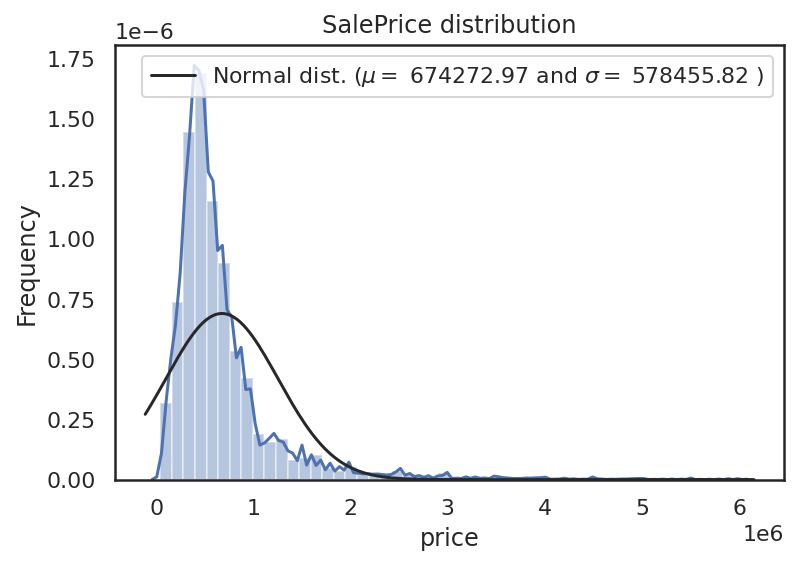

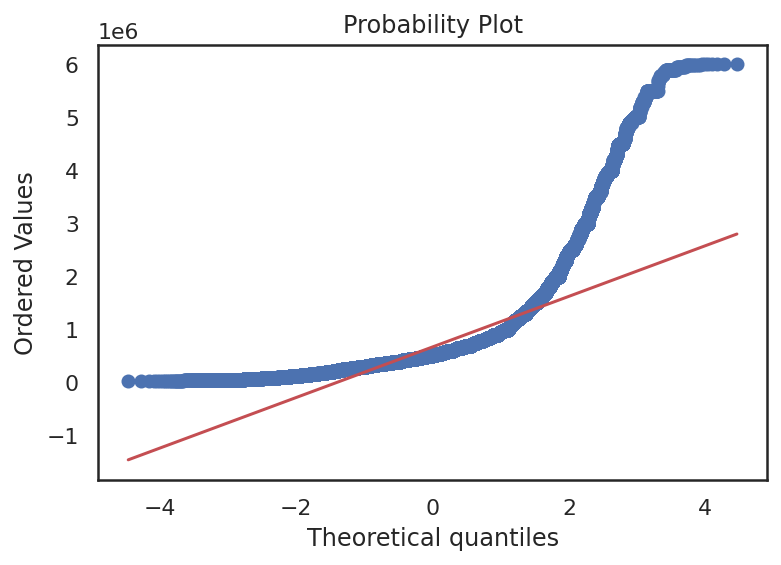

Skewness: 3.472372
Kurtosis: 17.459464


In [220]:
# Plot Histogram
sns.distplot(train_d['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_d['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_d['price'], plot=plt)
plt.show()

print("Skewness: %f" % train_d['price'].skew())
print("Kurtosis: %f" % train_d['price'].kurt())

### dążymy do rozkładu normalnego, jak widac logaritmizacja ceny może być dobrą praktyką w tym momencie 


 mu = 13.19 and sigma = 0.67



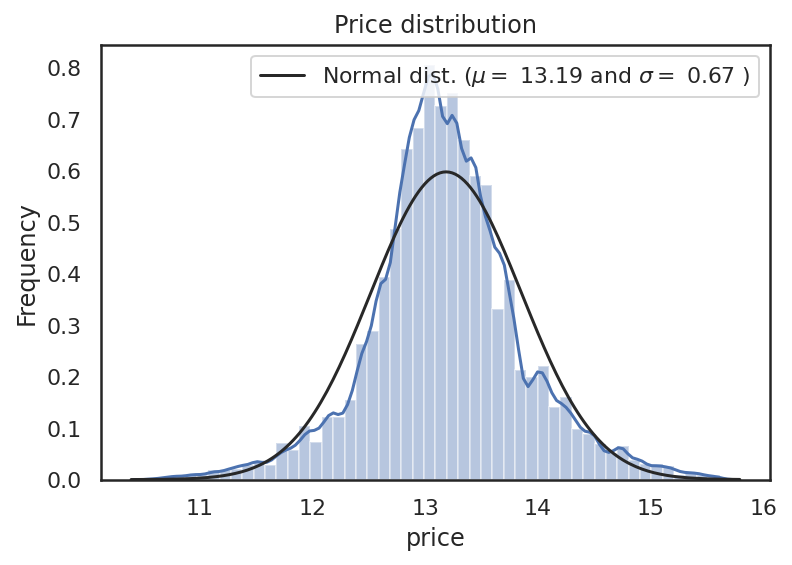

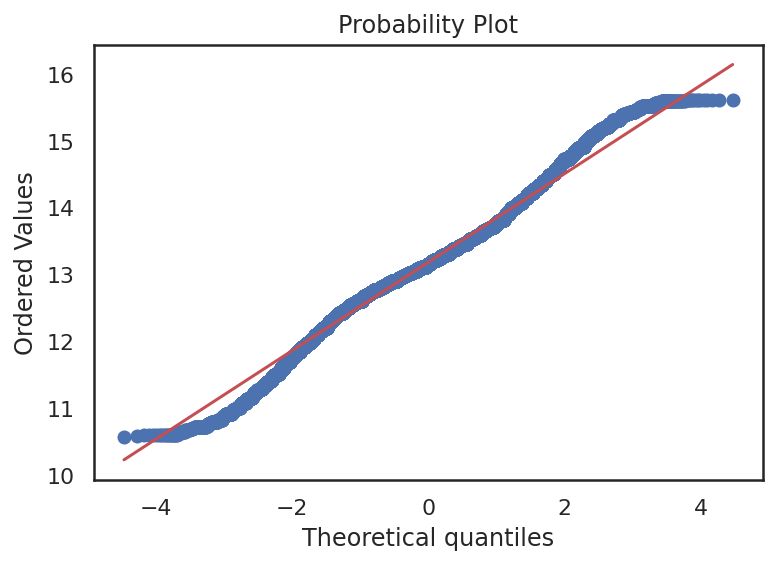

Skewness: 0.089539
Kurtosis: 1.122963


In [221]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_d["price"] = np.log1p(train_d["price"])

#Check the new distribution 
sns.distplot(train_d["price"] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_d["price"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(train_d['price'], plot=plt)
plt.show()

y_train_d = train_d.price.values

print("Skewness: %f" % train_d['price'].skew())
print("Kurtosis: %f" % train_d['price'].kurt())

### Po logarytmizacji, skośność oraz kurtoza są na satysfakcjonującym poziomie, a rozkład przypomina już dużo bardziej rozkład normalny. Z tymi wiadomościami predykcja odbęcie sie na zlogarytmizowanych cenach.

## MIESZKANIA

### Przypisanie 'train' oraz 'test' do ogłoszeń odnoszących się do mieszkań, jako 'test_m' oraz 'train_m'

kroki odbywają się analogicznie do kroków w domach z małymi zmianami

In [78]:
train_m = train[train['category']=='Mieszkanie na sprzedaż']

test_m = test[test['category']=='Mieszkanie na sprzedaż']

In [79]:
train_m_ID = train_m['id']
test_m_ID = test_m['id']

In [80]:
train_m = train_m.drop(['category', 
                    'cable_television', 'cable-television'], axis=1)

test_m = test_m.drop(['category',
                  'cable_television', 'cable-television'], axis=1)

In [81]:
print("\nThe train_m data size after dropping category feature is : {} ".format(train_m.shape)) 
print("The test_m data size after dropping category feature is : {} ".format(test_m.shape))


The train_m data size after dropping category feature is : (654841, 92) 
The test_m data size after dropping category feature is : (111251, 91) 


In [82]:
# Combining Datasets
ntrain_m = train_m.shape[0]
ntest_m = test_m.shape[0]
y_train_m = train_m.price.values
print(y_train_m.shape)
all_data = pd.concat((train_m, test_m)).reset_index(drop=True)
all_data.drop(['price'], axis=1, inplace=True)
print("train_m data size is : {}".format(train_m.shape))
print("test_m data size is : {}".format(test_m.shape))
print("Combined dataset size is : {}".format(all_data.shape))

(654841,)
train_m data size is : (654841, 92)
test_m data size is : (111251, 91)
Combined dataset size is : (766092, 91)


In [83]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
garret_type,99.999217
roof_type,99.998564
location,99.998173
roofing,99.997781
recreational,99.997389
terrain_area,99.994518
floors_num,99.992951
is_bungalow,99.990863
free_from,84.149815
rent,58.711225


In [84]:
all_data = all_data.drop(['floors_num',
'garret_type',
'roof_type',
'location',
'roofing',
'recreational',
'terrain_area',
'is_bungalow',
'free_from',
'rent',
'district_lat',
'district_lon',
'district_name',
'building_material',
'construction_status'], axis=1)

In [85]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
windows_type,35.284404
build_year,33.699347
district_id,24.943349
building_type,20.785885
rooms_num,0.000522
market,0.000261


In [86]:
# categorical missing data (we need to convert it to numerical before removing NaNs)
cat = list(all_data.select_dtypes(include=['object']).columns)
cat

['city_name', 'market', 'rooms_num', 'building_type', 'windows_type']

In [87]:
# windows_type unique values
un_windows_type = all_data['windows_type'].unique()
# building_type unique values
un_building_type = all_data['building_type'].unique()
# market unique values
un_market = all_data['market'].unique()
# city_name unique values
un_city_name = all_data['city_name'].unique()
# rooms_num unique values
un_rooms_num = all_data['rooms_num'].unique()

print(un_windows_type)
print(un_building_type)
print(un_market)
print(un_city_name)
print(un_rooms_num)

['plastic' 'wooden' nan 'aluminium']
[nan 'ribbon' 'block' 'apartment' 'tenement' 'house' 'infill' 'loft'
 'semi_detached' 'detached' 'tenement_house']
['secondary' 'primary' nan]
['Olsztyn' 'Plewiska' 'Białystok' ... 'Lanckorona' 'Gowino'
 'Klebark Wielki']
['4' '3' '2' '5' '1' '6' '7' '9' '8' '10' 'more' nan]


In [88]:
all_data['rooms_num'].unique()

array(['4', '3', '2', '5', '1', '6', '7', '9', '8', '10', 'more', nan],
      dtype=object)

In [89]:
all_data.rooms_num = all_data.rooms_num.replace('more',11)

In [90]:
# categorical missing data (we need to convert it to numerical before removing NaNs)
cat = list(all_data.select_dtypes(include=['object']).columns)
cat

['city_name', 'market', 'rooms_num', 'building_type', 'windows_type']

In [91]:
cat_feats = ['city_name', 'market', 'rooms_num', 'building_type', 'windows_type']

for feat in cat_feats:
    all_data[feat] = all_data[feat].factorize()[0]

In [92]:
cat = len(all_data.select_dtypes(include=['object']).columns)
num = len(all_data.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  0 categorical + 76 numerical = 76 features


In [93]:
# finding categorical data that is left 
cat = list(all_data.select_dtypes(include=['object']).columns)
cat

[]

In [94]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
build_year,33.699347
district_id,24.943349


In [95]:
# build year
all_data['build_year'] = all_data['build_year'].fillna(all_data['build_year'].mode()[0])
# terrain_area 
all_data['district_id'] = all_data['district_id'].fillna(all_data['district_id'].mode()[0])

In [96]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


In [97]:
train_m = all_data[:ntrain_m]
test_m = all_data[ntrain_m:]

In [98]:
train_m = pd.concat([train_m, pd.DataFrame(columns=['price'], data=y_train_m)], axis=1)

In [99]:
lower_bound = 0.001
upper_bound = 0.999

res = train_m.price.quantile([lower_bound, upper_bound])
res

0.001      25000.0
0.999    3599000.0
Name: price, dtype: float64

In [100]:
lower_bound = 0.001
upper_bound = 0.999

res = train_m.m.quantile([lower_bound, upper_bound])
res

0.001     16.000
0.999    261.096
Name: m, dtype: float64

In [101]:
lower_bound = 0.0015
upper_bound = 0.99

res = train_m.build_year.quantile([lower_bound, upper_bound])
res

0.0015    1856.0
0.9900    2020.0
Name: build_year, dtype: float64

In [102]:
#price
train_m = train_m[(train_m['price']<4599000.0) & (train_m['price']>20000.0)]
#floor_area
train_m = train_m[(train_m['m']<286.096) & (train_m['m']>16.000)]
#build_year
train_m = train_m[(train_m['build_year']<2021.000) & (train_m['build_year']>1456.000)]


 mu = 380730.61 and sigma = 270010.83



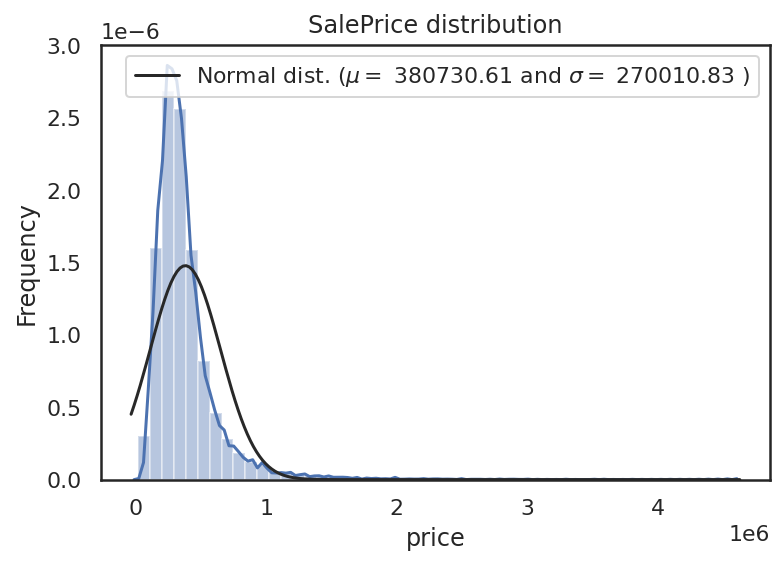

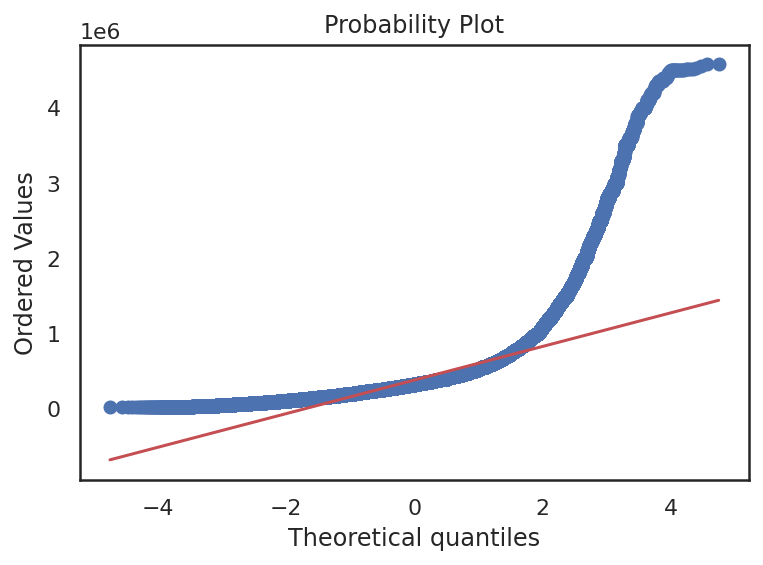

Skewness: 4.259631
Kurtosis: 33.132965


In [103]:
# Plot Histogram
sns.distplot(train_m['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_m['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_m['price'], plot=plt)
plt.show()

print("Skewness: %f" % train_m['price'].skew())
print("Kurtosis: %f" % train_m['price'].kurt())


 mu = 12.69 and sigma = 0.55



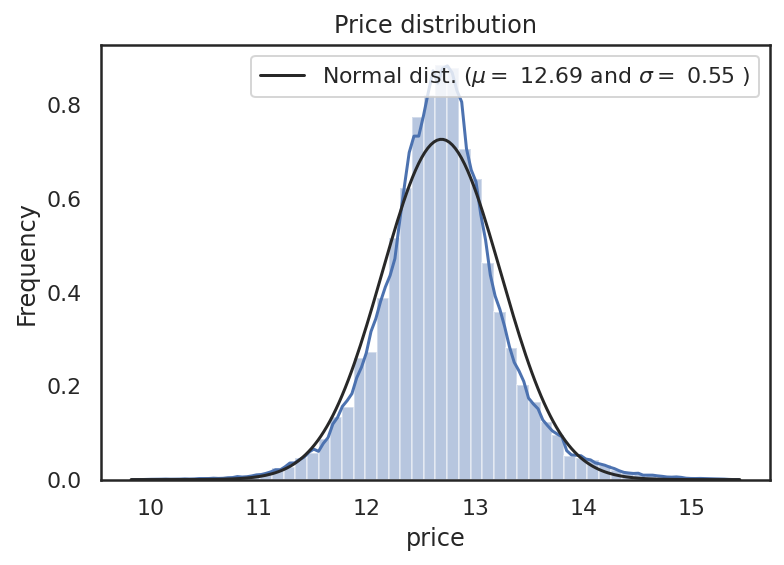

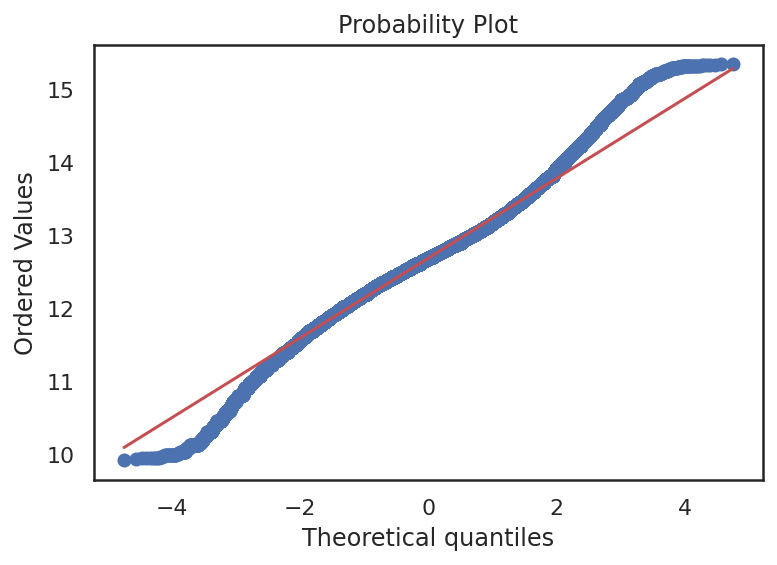

Skewness: 0.163001
Kurtosis: 1.362466


In [104]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_m["price"] = np.log1p(train_m["price"])

#Check the new distribution 
sns.distplot(train_m["price"] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_m["price"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(train_m['price'], plot=plt)
plt.show()

y_train_m = train_m.price.values

print("Skewness: %f" % train_m['price'].skew())
print("Kurtosis: %f" % train_m['price'].kurt())

# Etap predykcja:


1. uzasadnij wybór użytego algortymu/modelu,
2. załaduj stworzony model,
3. dokonaj predykcji dla zbioru walidacyjnego i zmierz jej jakość.

### Na tym etapie predykcja modeli również przebiega oddzielnie dla domów oraz mieszkań. Domy zostaną opisane szczegółowo natomiast w przypadku mieszkań nastapiło analogiczne wnioskowanie.

# Model

Po długich rozważaniach i wielu próbach z wykorzystaniem innych algorytmów (AdaBoost, CatBoost, Lasso-Regressor, ElasticNet i innych), a nawet stackowaniem rezultatów otrzymywanych z wyżej wymienionych algorytmów, postawiliśmy na XGBoosta (eXtreme Gradient Boosting).

Biblioteka XGBoost implementuje algorytm Gradient Boosting. 
Boosting to technika, w której nowe modele dodawane są (co iterację) w celu skorygowania błędów popełnianych przez istniejące estymatory. Nowe modele tworzy się minimalizując odchylenia (wartości predykowanych od rzeczywistych), przy użyciu algorytmu spadku gradientu (Gradient Descent). Modele są dodawane sekwencyjnie, aż do momentu, w którym nie będzie można dokonać dalszych ulepszeń. 

Podstawowym kryterium jakie braliśmy pod uwagę wybierająć XGBoosta była oczywiście jakość predykcji jaką zapewniał nam model, warto zauważyć, żę dla pojedyńczego modelu uzyskiwaliśmy lepsze wyniki niż w przypadku stackowania predykcji kilku innych algorytmów na potrzeby uczenia meta-modelu. XGBoost jest także jednym z najszybszych narzędzi implementujących technikę Gradient Boostingu, co okazało się niezwykle wartościowe przy wielokrotnym trenowaniu modelu po zmianach, wprowadzanych na wcześniejszych etapach. Nie bez znaczenia pozostaje także wyczerpująca dokumentacja biblioteki, znacznie ułatwiająca rozpoczęcie pracy nad modelem.     

In [3]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=8, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state=7)

# Załadowanie modelu

W komórce poniżej zamieszczamy "wytrenowany" na zbiorze uczącym model dla domów. 

In [4]:
model_xgb = xgb.XGBRegressor()  # init model
model_xgb.load_model('final_houses_model.model')  # load pre-trained model

[20:05:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Tworzenie zbioru walidacyjnego

In [5]:
validation = train.sample(frac=0.33) 

In [6]:
validation_prices = np.expm1(validation.price.values)
print(validation_prices.shape)
validation.drop(['price'], axis=1, inplace=True)
print(validation.columns)

(57195,)
Index(['is_business', 'city_id', 'region_id', 'city_lon', 'city_lat',
       'terrain_area', 'm', 'market', 'rooms_num', 'building_type',
       'floors_num', 'building_material', 'build_year', 'construction_status',
       'windows_type', 'is_bungalow', 'air_conditioning', 'asphalt_access',
       'attic', 'balcony', 'basement', 'elevator', 'furniture', 'garage',
       'garden', 'heating', 'lift', 'parking', 'pool', 'separate_kitchen',
       'terrace', 'two_storey', 'usable_room', 'cesspool', 'electricity',
       'gas', 'internet', 'phone', 'sewage', 'water', 'water_purification',
       'alarm', 'anti_burglary_door', 'closed_area', 'entryphone',
       'monitoring', 'roller_shutters', 'biomass', 'coal', 'electric',
       'fireplace', 'gas.1', 'geothermal', 'heat_pump', 'oil',
       'solar_collector', 'stove', 'urban', 'brick', 'concrete', 'hedge',
       'metal', 'other', 'wire', 'wooden', 'forest', 'lake', 'mountains',
       'open_terrain', 'sea', 'asphalt', 'dirt', '

# Wykonujemy predykcje dla zbioru walidacyjnego 

Wcześniej dopasowany do obserwacji ze zbioru treningowego model, będzie predykował ceny domów (model jest już "wyternowany" (krzywa regresji jest już wyznaczona), co za tym idzie poniższa instrukcja wymaga od programu jedynie umiejscowienie obserwacji ze zbioru walidacyjnego na krzywej regresji i odczytanie przewidywanej (najbliższej) ceny.  

In [7]:
xgb_validation_pred = np.expm1(model_xgb.predict(validation))

# Ocena jakości predykcji dla zbioru walidacyjnego

Do oceny jakości predykcji posłużyliśmy się klasycznymi, w przypadku problemu regresji, metrykami oceniającymi jakość predykcji modelu (wszystkie miary bazują na "odległości" wartości predyckji od rzeczywistej wartości ogłoszenia).

1) MAE - Mean Absolute Error (miara jest uśrednioną dla wszystkich obserwacji wartością bezwzględną z różnicy między predykcją a rzeczywistą wartością (w tym przypadku rzeczywistą ceną ogłoszenia). Miara ta daje dobry pogląd o tym jak niepoprawne są predykcje modelu, nie wskazuje jadnak czy model zaniża czy zawyża poziom predykcji.)

W naszym przypadku (model dla domów) osiągnął wynik MAE = 77848.65 co znaczy, że średnie odchylenie predykcji od rzeczywistej wartości ogłoszenia wynosiło ok. 77 tys. zł. 

2) MSE - Mean Squared Error (miara jest kwadratem "odległości" pomiędzy wartością predykcji a wartości rzeczywistej, jest ona szczególnie wrażliwa na znaczne odchylenia)

3) RMSE - Root Mean Squared Error (to pierwiastek kadratowy z poprzedniej miary (z racji na to także bardzo wrażliwy na występowanie wartości ekstremalnych), dzięki zastosowaniu pierwiastka kwadratowego sprowadzamy wartość pomiaru błędu kwadratowego do oryginalnych jednostek. 

W naszym przypadku (model dla domów) osiągnął wynik RMSE = 166011.95 co znaczy, że model średnio myli się o ok 166 tys. zł. 

4) R^2 - Coefficient of determination (miara dopasowania modelu do obserwacji ze zbioru treningowego, choć istnieją lepsze metody pomiaru dopasowania, umożliwiające zdefiniowanie przyczynowości to R^2 jest nadal często stosowaną miarą a jej wzrost jednoznacznie wskazuje na poprawę dopasowania modelu. 

Literatura wskazuje poziom R^2 = 0.9 jako bardzo dobre dopasowanie, nasz model (dla domów) osiągnął wartość R^2 = 0.92029, co stanowiło dla nas sygnał, że wykorzystanie regresji liniowej do zbudowania modelu było słuszną decyzją. 


Poniższa komórka prezentuje wartości miar błędu predykcji wyznaczone z pomocą popularnej biblioteki machine learningowej Scikit-learn. 

In [9]:
predMetrics()

Linear Regression Performance
MAE = 77848.65979919299
MSE = 27559968484.007355
RMSE = 166011.9528347503
R^2 = 0.9202868159175249


# Etap analizy predykcji:

### Etap ten został zaprezentowany tylko dla modelu dot. domów

1. przeanalizuj wpływ poszczególnych cech na predykcję,
2. zaprezentuj i wytłumacz na konkretnym przykładzie lub przykładach jak jego/ich cechy wpływają na predykcję. Jak zmieni się predykcja jeśli zmienimy którąś z cech?
3. porównaj ze sobą dwa ogłoszenia z tej samej kategorii o różnych cenach i wytłumacz za pomocą modelu różnicę w cenie,
4. jeśli chcesz możesz zaprezentować też dodatkowe analizy,
5. wnioski.

6. Odpowiedz na dodatkowe pytania:
    
    6.1. Co Twoim zdaniem mogłoby zwiększyć jakość predykcji? (np. inne kategorie danych (jakie?), zwiększenie możliwości związanych z przetwarzaniem danych, itp.)
    
    6.2. Do czego wykorzystałbyś ten model w serwisie Otodom? Czy widzisz dla niego jakieś praktyczne zastosowania?


# Feature importance - wpływ poszczególnych cech na predykcję 

Wykorzystanie algorytmu opartego o technikę Gradient Boostingu, jest szczególnie korzystne w przypadku interpretacji ważności zmiennych w modelu. 

W poniższej komórce skorzystaliśmy z metody feature_importances_ pakietu XGBoost, dzięki której uzyskaliśmy wyniki istotności poszczególnych zmiennych wykorzystywanych w modelu. Wynik istotności cechy wzrasta wraz ze zwiększającą się liczbą decyzji drzewa decyzyjnego opierającego sie o wartość konkretnej cechy. Istotność jest wyznaczana dla każdej cechy wykorzystywanej w modelu co pozwala na łatwe sortowanie uzyskanych rezultatów.  

Poniżej prezentujemy ranking cech oraz jego wizualizację w postaci histogramów. 

In [10]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = validation.columns.tolist()
feature_importance_df['importances'] = model_xgb.feature_importances_.tolist()

feature_importance_df = feature_importance_df.sort_values(by='importances', ascending=False)
feature_importance_df['importances'] = feature_importance_df['importances']*100

pd.set_option("display.max_rows", None)

In [12]:
featImportances()

,features,importances
6,m,8.531805
8,rooms_num,6.951023
41,alarm,4.938266
13,construction_status,4.237304
77,closest_city,3.704131
1,city_id,3.192989
51,gas.1,2.816785
23,garage,2.413068
35,gas,2.357059
2,region_id,2.162877


In [13]:
most_valuable_features = feature_importance_df.head(20)

Dwadzieścia cech, wraz z ich wskaźnikiem istotności, których wartości obserwacji najśilniej wpływają na predykcję wykonywana przez model. 

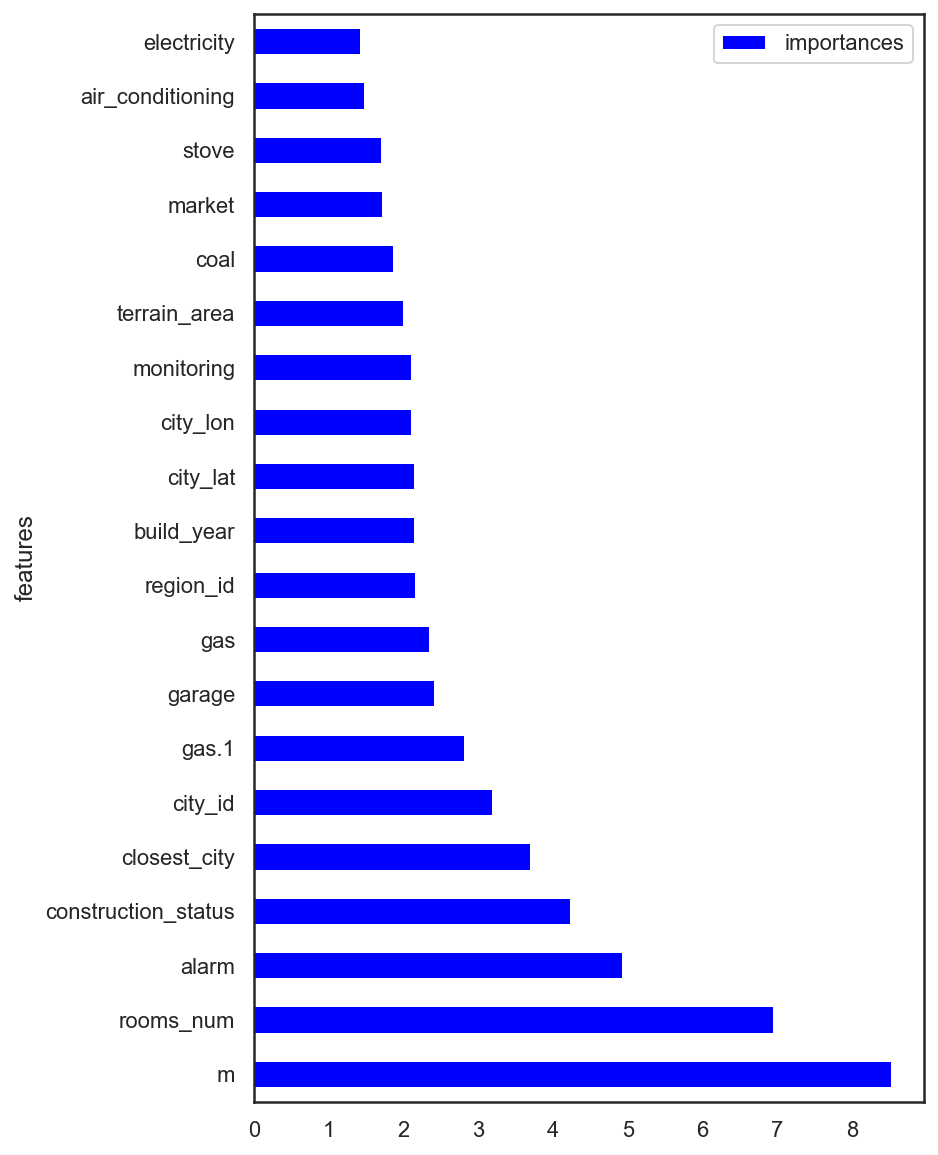

In [15]:
valuableFeaturesPlot()

In [16]:
most_useless_features = feature_importance_df.tail(20)

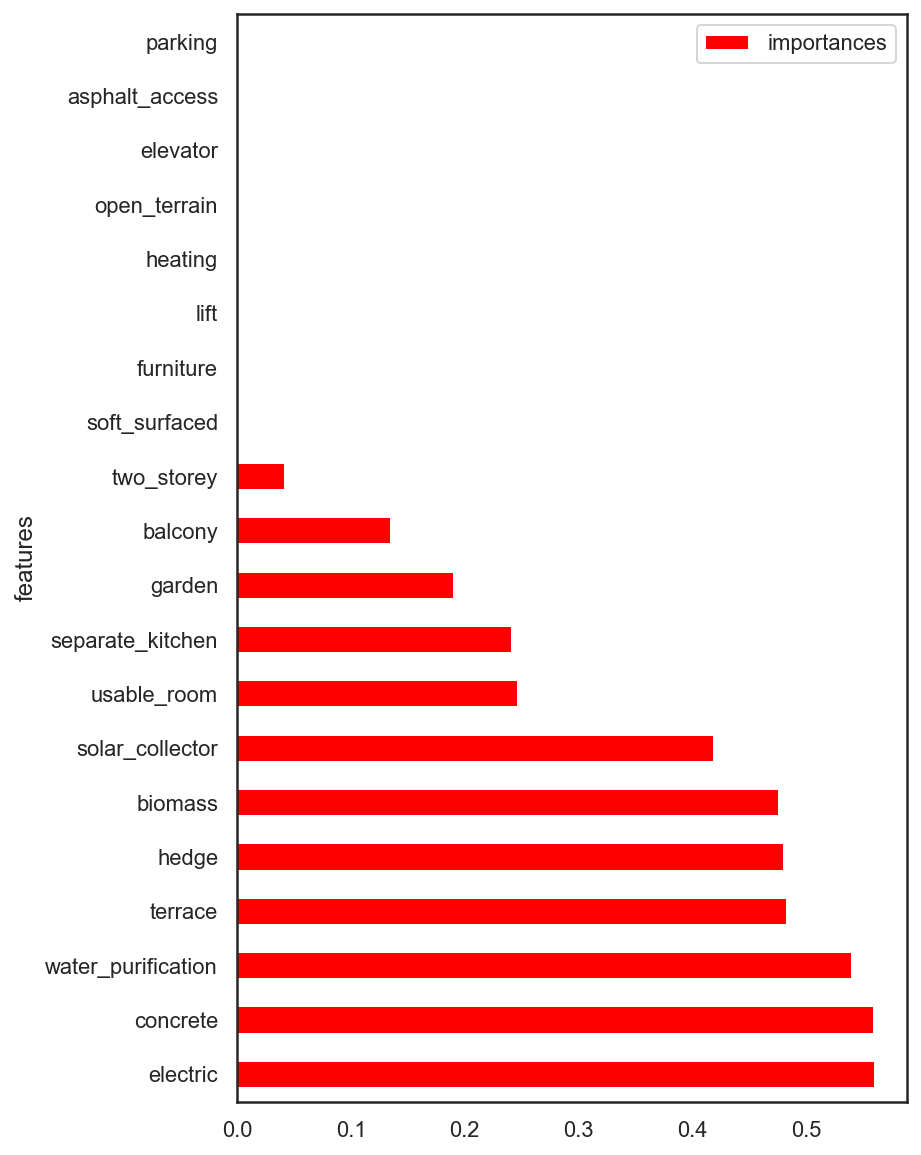

In [18]:
uselessFeaturesPlot()

Jak widać na powyższym histogramie nie wszystkie zmienne w naszym modelu wpływają na wartość predykcji. Rozsądnym rozwiązaniem jest usunięcie kolumn z zerową ważnością dla modelu (nadmiarowe kolumny niepotrzebnie zwiększają rozmiar zbiorów treningowych i testowych). 

# Wpływ zmiany wartości cechy na predykcję

Dzięki wskaźnikowi istotności omawianemu powyżej znamy ranking istotności cech w modelu. Jednak wynik punktowy wskaźnika,
słabo wizualizuje faktyczny wpływ zmiany wartości poszczególnych cech na wartość predykcji. 
W celu zwizalizowania wpływu zmiany wartości poszczególnych cech na predykcje wyznaczane przez model,
skonstruowaliśmy funkcję, umożliwiającą wybranie interesującej nas zmiennej, jak i zadeklarowanie zupełnie nowej wartości tej cechy, (przy pozostałych wartościach cech stałych). Funkcja ma za zadanie wizualizacje zmiany w poziomie predykcji w zależności od nowej wartości wybranej cechy.

In [19]:
def get_prediction_difference(df, choosen_feat_label, new_feat_value):
    
    """Ta funkcja ma za zadanie pokazanie różnicy w poziomie predykcji dokonanej przez nasz model,
        w zależności od zmiany wartości jednej cechy (wszystkie pozostałe cechy są stałe)"""
    
    if choosen_feat_label in df.columns:
        # losowe wybranie wiersza z danego data framu
        selected_row = df.sample()
        # zapisanie tego samego wiersza też w drugiej zmiennej bo jedną zmieniamy a drugą zostawiamy niezmienioną
        unchanged_row = selected_row.copy(deep=True)
        # zapisanie oryginalnej wartości wybranej zmiennej
        original_feat_value = unchanged_row[choosen_feat_label].values[0]
        # wybranie zmiennej wskazanej przez usera i przypisanie jej nowej wartości
        selected_row[choosen_feat_label].replace(to_replace=original_feat_value,
                                                 value=new_feat_value, inplace=True)
        # wykonanie predykcji
        # dla zmienionego wiersza
        selected_row_pred = np.expm1(model_xgb.predict(selected_row)[0])
        # dla niezmienionego wiersza (unchanged_row_pred = cena - predykowana)
        unchanged_row_pred = np.expm1(model_xgb.predict(unchanged_row)[0])
        # obliczenie różnicy w poziomie predykcji
        diff_in_pred = abs(unchanged_row_pred - selected_row_pred)
        # Spakowanie wszystkiego do data frame
        unchanged_data = {'status': 'unchanged',
                          choosen_feat_label: original_feat_value,
                          'predicted_price': format(unchanged_row_pred, '.2f')}
        
        changed_data = {'status': 'changed',
                         choosen_feat_label: new_feat_value,
                        'predicted_price': format(selected_row_pred, '.2f')}
        
        result_df = pd.DataFrame(columns=['status', choosen_feat_label, 'predicted_price'],
                                 data=[unchanged_data, changed_data])
    else:
        print("Nie ma takiej zmiennej w zbiorze walidacyjnym!")
    
    # wyprintowanie różnicy w predykcji
    print(f"Absolutna różnica w poziomie predykcji zależna jedynie od zmiennej {choosen_feat_label} wynosi {format(diff_in_pred, '.2f')}zł.")
    
    return result_df

Poniższy przykład odnosi sie do zmiennej terrain_area reprezentującej wielkość działki należącej do sprzedawanej nieruchomości w metrach kwadratowych. Wartość wskaźnika tej zmiennej oscyluje w granicach dwójki, zatem jest to jedna z najważniejszych zmiennych w naszym modelu. W poniższej komórce obserwujemy znaczny wzrost wartości zmiennej terrain_area (ok. 10 000 m2), co wiąże się w tym przypadku ze wzrostem ceny nieruchomości o ponad 250 tys. złotych, co jest zgodne z oczekiwaniami przy tak znacznym przyroście powierzchni działki.  

In [27]:
firstDataChangeCell1()

Absolutna różnica w poziomie predykcji zależna jedynie od zmiennej terrain_area wynosi 260595.62zł.


,status,terrain_area,predicted_price
0,unchanged,1118.0,476921.12
1,changed,10187.0,737516.75


Kolejny przykład odnosi sie do zmiennej skonstruowanej przez nasz zespół na etapie feature engineering. Cecha closest_city zostaje wyliczona na podstawie danych - długości i szerokości geograficznej. Do obliczenia odległości od najbliższego miasta znajdującego się w pliku cities, wykorzystujemy te same dane dla miast w nim zawartych. Wartość zmiennej jest reprezentuje ogległość między nieruchomością a najbliższym miastem. Co ciekawe, skonstruowana w ten sposób zmienna znalazła się na piątym miejscu w rankingu wskaźnika istotności (co jest zgodne z intuicją - im dalej od miasta znajduję sie nieruchomość tym jej wartośc jest mniejsza, jest to oczywiście przybliżenie a nie ogólna zasada). W tym przypadku istotnośc została odzwierciedlona w wartości predykcji, której wartość, po manipulacji zmienną, zmalała o całe sto tysięcy złotych. 

In [23]:
secondDataChangeCell()

Absolutna różnica w poziomie predykcji zależna jedynie od zmiennej closest_city wynosi 102432.41zł.


,status,closest_city,predicted_price
0,unchanged,17.550,432244.28
1,changed,98.056,329811.88


W odróżnieniu od dwóch poprzednich cech, zmienna 'blacony', znajduje sie na końcu rankingu wskażnika istotności. Ma to swoje odzwierciedlenie w przykładzie poniżej, zgodnie z naszym modelem to czy badana (w tym przypadku) nieruchomosć ma balkon czy też nie, zmienia wartość jedynie o ok 200 złotych. Co ciekawe obecność balkonu (w tym przypadku) wpływa na spadek wartości predykcji. 

In [25]:
thirdDataChangeCell()

Absolutna różnica w poziomie predykcji zależna jedynie od zmiennej balcony wynosi 204.22zł.


,status,balcony,predicted_price
0,unchanged,0,445281.00
1,changed,1,445076.78


# Porównanie dwóch ogłoszeń w kategorii domy

In [178]:
sub.loc[sub['id'] == 641346.0]

,id,price
111267,641346,362128.44


In [179]:
sub.loc[sub['id'] == 250604.0]

,id,price
111251,250604,905517.4


Cecha 'm', 'rooms_num', 'alarm', 'construction_status' oraz 'closest_city' są 5 cechami, które najbardziej wpływają na model. Można to zauważyć to na przykładzie powyżej zaprezentowany. 

Mieszkanie o przewidzianej cenie 362128.44 zł posiada powierzchnię o 168 metrach kwadratowych, posiada 6 pokoi, nie posiada alarmu, jego status jest określany jako 'do renowacji' oraz jest oddalony od nabliższego dużego miasta o 35.31 km. 

Cena drugiego mieszkania została przewidziana na 905517.4 zł. Metrarz wynosi 264 m2, posiada tylko 4 pokoje, nie posiada alarmu ale jest gotowy do użytku oraz znajduje się niecałe 20 km od najbliższego dużego miasta.

Z powyższych przykładów wnioskować można, iż znacząca różnica w cenach jest uargumentowana informacjami w modelu.

# Wnioski

Według nas cały proces został przeprowadzony w dość ciekawy i niebanalny sposób. Zaznaczając, iż jest to pierwsza próba predykowania cen (dla całego zespołu), wynik również jest satysfakcjonujący. 

Nowe zmienne stworzone podczas etapu 'feature engineering' poprawiały model w znacznym stopniu co również pokazuje kreatywność zespołu. Zabrakło napewno czasu na dołożenie dodatkowych starań w konkursie, lecz jest to już kwestia indywidualna. 

Sprawdziliśmy wiele podejść i metodą prób oraz błędów, w procesie nauki, doszliśmy do zadowalających wyników. Próbę oceniamy na pożądną czwórkę. W procesie nauki doszliśmy do momentu, w którym byliśmy w stanie określić, który model będzie tym odpowiednim do opisania i da najlepsze wyniki. Próba powiodła się, ponieważ wybrany model końcowy nie dawał najlepszych wyników w 'Public Leaderboard', aczkolwiek już w 'Private Leaderboard' udało nam się przeskoczyć o miejsce wyżej oraz osiągnąć lepsze wyniki o ok. 5 tys. Ostatecznie wybrany model okazał się dawać również najlepsze wyniki w 'Private Leaderboard' ze wszystkich modeli, których podjęta została próbę wrzucenia na kaggle.  

Liczymy, że cały opis jest zrozumiały. W razie wątpliwości jesteśmy do dyspozycji. 

Kontakt: 

1. damian.klimarczyk@gmail.com
2. oskar.dolzkiewicz@gmail.com